In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
np.random.seed(777)
import math
import keras
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout, concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.regularizers import l2
from keras.applications.xception import Xception, preprocess_input
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications import DenseNet201
from keras.applications import DenseNet121

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import SeparableConv2D, AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

Using TensorFlow backend.


In [3]:
train_dir = 'data/bioimaging/train/'
test_dir = "data/bioimaging/test/"

extracted_features_dir = "extracted_features/"
model_name = "bioimaging_densenet"

In [4]:
import keras
import tensorflow as tf
import keras.backend as K

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.9.0
dim_ordering: tf


In [5]:
batch_size = 32
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
epochs = 1000

In [6]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data/bioimaging/train/ 0
data/bioimaging/train/carcinoma 5696
data/bioimaging/train/non-carcinoma 5696
******************************
data/bioimaging/test/ 0
data/bioimaging/test/carcinoma 36
data/bioimaging/test/non-carcinoma 35


In [7]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 8544 images belonging to 2 classes.
Found 2848 images belonging to 2 classes.
Found 71 images belonging to 2 classes.


In [8]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

nb_test_samples = len(test_generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

# nb_test_without_aug_samples = len(test_generator_without_aug.filenames)
# predict_size_test_without_aug = int(math.ceil(nb_test_without_aug_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
# print("nb_test_without_aug_samples:", nb_test_without_aug_samples)
# print("predict_size_test_without_aug_samples:", predict_size_test_without_aug)
print("nb_test_samples:", nb_test_samples)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 8544
nb_validation_samples: 2848

predict_size_train: 267
predict_size_validation: 89
nb_test_samples: 71
predict_size_test: 3

 num_classes: 2


In [9]:
from keras.backend.tensorflow_backend import get_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import set_session

def reset_keras_tf_session():
    """
    this function clears the gpu memory and set the 
    tf session to not use the whole gpu
    """
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

#     config = tf.ConfigProto()
#     config.gpu_options.allow_growth = True
#     set_session(tf.Session(config=config))


reset_keras_tf_session()

In [10]:
from keras.applications.mobilenetv2 import MobileNetV2
from keras.applications.densenet import DenseNet169
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.nasnet import NASNetMobile

input_tensor = Input(shape = input_shape)  
model = DenseNet201(weights='imagenet', include_top=False, pooling = 'avg', input_tensor=input_tensor)
bottleneck_final_model = model

In [11]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_1
1 zero_padding2d_1
2 conv1/conv
3 conv1/bn
4 conv1/relu
5 zero_padding2d_2
6 pool1
7 conv2_block1_0_bn
8 conv2_block1_0_relu
9 conv2_block1_1_conv
10 conv2_block1_1_bn
11 conv2_block1_1_relu
12 conv2_block1_2_conv
13 conv2_block1_concat
14 conv2_block2_0_bn
15 conv2_block2_0_relu
16 conv2_block2_1_conv
17 conv2_block2_1_bn
18 conv2_block2_1_relu
19 conv2_block2_2_conv
20 conv2_block2_concat
21 conv2_block3_0_bn
22 conv2_block3_0_relu
23 conv2_block3_1_conv
24 conv2_block3_1_bn
25 conv2_block3_1_relu
26 conv2_block3_2_conv
27 conv2_block3_concat
28 conv2_block4_0_bn
29 conv2_block4_0_relu
30 conv2_block4_1_conv
31 conv2_block4_1_bn
32 conv2_block4_1_relu
33 conv2_block4_2_conv
34 conv2_block4_concat
35 conv2_block5_0_bn
36 conv2_block5_0_relu
37 conv2_block5_1_conv
38 conv2_block5_1_bn
39 conv2_block5_1_relu
40 conv2_block5_2_conv
41 conv2_block5_concat
42 conv2_block6_0_bn
43 conv2_block6_0_relu
44 conv2_block6_1_conv
45 conv2_block6_1_bn
46 conv2_block6_1_relu
47 conv2_block

697 conv5_block31_concat
698 conv5_block32_0_bn
699 conv5_block32_0_relu
700 conv5_block32_1_conv
701 conv5_block32_1_bn
702 conv5_block32_1_relu
703 conv5_block32_2_conv
704 conv5_block32_concat
705 bn
706 relu
707 avg_pool


In [12]:
c1 = model.layers[9].output 
c1 = GlobalAveragePooling2D()(c1)       

c2 = model.layers[55].output
c2 = GlobalAveragePooling2D()(c2)       

c3 = model.layers[143].output
c3 = GlobalAveragePooling2D()(c3)       

c4 = model.layers[483].output
c4 = GlobalAveragePooling2D()(c4)

con = concatenate([c1, c2, c3, c4])

bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [13]:
bottleneck_final_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

                                                                 conv4_block11_2_conv[0][0]       
__________________________________________________________________________________________________
conv4_block12_0_bn (BatchNormal (None, 14, 14, 608)  2432        conv4_block11_concat[0][0]       
__________________________________________________________________________________________________
conv4_block12_0_relu (Activatio (None, 14, 14, 608)  0           conv4_block12_0_bn[0][0]         
__________________________________________________________________________________________________
conv4_block12_1_conv (Conv2D)   (None, 14, 14, 128)  77824       conv4_block12_0_relu[0][0]       
__________________________________________________________________________________________________
conv4_block12_1_bn (BatchNormal (None, 14, 14, 128)  512         conv4_block12_1_conv[0][0]       
__________________________________________________________________________________________________
conv4_bloc

conv4_block45_0_relu (Activatio (None, 14, 14, 1664) 0           conv4_block45_0_bn[0][0]         
__________________________________________________________________________________________________
conv4_block45_1_conv (Conv2D)   (None, 14, 14, 128)  212992      conv4_block45_0_relu[0][0]       
__________________________________________________________________________________________________
conv4_block45_1_bn (BatchNormal (None, 14, 14, 128)  512         conv4_block45_1_conv[0][0]       
__________________________________________________________________________________________________
conv4_block45_1_relu (Activatio (None, 14, 14, 128)  0           conv4_block45_1_bn[0][0]         
__________________________________________________________________________________________________
conv4_block45_2_conv (Conv2D)   (None, 14, 14, 32)   36864       conv4_block45_1_relu[0][0]       
__________________________________________________________________________________________________
conv4_bloc

In [14]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [15]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [16]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [17]:
dropout_rate = 0.4

model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation=tf.nn.softmax))

adam_opt2=Adam(lr = 0.0001, beta_1=0.6, beta_2=0.9, amsgrad=False)

model.compile(optimizer=adam_opt2, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

# model.save_weights(top_model_weights_path)
# model.save(top_model_path)

Train on 8544 samples, validate on 2848 samples
Epoch 1/1000
 - 4s - loss: 0.6807 - acc: 0.5918 - val_loss: 0.6655 - val_acc: 0.6949
Epoch 2/1000
 - 1s - loss: 0.6539 - acc: 0.6640 - val_loss: 0.6386 - val_acc: 0.6991
Epoch 3/1000
 - 1s - loss: 0.6281 - acc: 0.6879 - val_loss: 0.6127 - val_acc: 0.7093
Epoch 4/1000
 - 1s - loss: 0.6049 - acc: 0.6918 - val_loss: 0.5925 - val_acc: 0.7107
Epoch 5/1000
 - 1s - loss: 0.5874 - acc: 0.7031 - val_loss: 0.5768 - val_acc: 0.7096
Epoch 6/1000
 - 1s - loss: 0.5726 - acc: 0.7106 - val_loss: 0.5646 - val_acc: 0.7212
Epoch 7/1000
 - 1s - loss: 0.5613 - acc: 0.7179 - val_loss: 0.5514 - val_acc: 0.7272
Epoch 8/1000
 - 1s - loss: 0.5535 - acc: 0.7213 - val_loss: 0.5427 - val_acc: 0.7384
Epoch 9/1000
 - 1s - loss: 0.5455 - acc: 0.7266 - val_loss: 0.5381 - val_acc: 0.7314
Epoch 10/1000
 - 1s - loss: 0.5354 - acc: 0.7326 - val_loss: 0.5263 - val_acc: 0.7430
Epoch 11/1000
 - 1s - loss: 0.5303 - acc: 0.7336 - val_loss: 0.5185 - val_acc: 0.7507
Epoch 12/1000
 

Epoch 96/1000
 - 1s - loss: 0.2669 - acc: 0.8861 - val_loss: 0.2580 - val_acc: 0.8862
Epoch 97/1000
 - 1s - loss: 0.2644 - acc: 0.8890 - val_loss: 0.2529 - val_acc: 0.8915
Epoch 98/1000
 - 1s - loss: 0.2635 - acc: 0.8888 - val_loss: 0.2522 - val_acc: 0.8926
Epoch 99/1000
 - 1s - loss: 0.2617 - acc: 0.8845 - val_loss: 0.2497 - val_acc: 0.8936
Epoch 100/1000
 - 1s - loss: 0.2584 - acc: 0.8917 - val_loss: 0.2528 - val_acc: 0.8975
Epoch 101/1000
 - 1s - loss: 0.2582 - acc: 0.8904 - val_loss: 0.2476 - val_acc: 0.8947
Epoch 102/1000
 - 1s - loss: 0.2561 - acc: 0.8917 - val_loss: 0.2507 - val_acc: 0.8890
Epoch 103/1000
 - 1s - loss: 0.2559 - acc: 0.8902 - val_loss: 0.2432 - val_acc: 0.8968
Epoch 104/1000
 - 1s - loss: 0.2510 - acc: 0.8948 - val_loss: 0.2420 - val_acc: 0.8968
Epoch 105/1000
 - 1s - loss: 0.2525 - acc: 0.8926 - val_loss: 0.2402 - val_acc: 0.8978
Epoch 106/1000
 - 1s - loss: 0.2511 - acc: 0.8944 - val_loss: 0.2398 - val_acc: 0.8996
Epoch 107/1000
 - 1s - loss: 0.2473 - acc: 0.89

Epoch 191/1000
 - 1s - loss: 0.1523 - acc: 0.9436 - val_loss: 0.1448 - val_acc: 0.9466
Epoch 192/1000
 - 1s - loss: 0.1530 - acc: 0.9417 - val_loss: 0.1432 - val_acc: 0.9452
Epoch 193/1000
 - 1s - loss: 0.1508 - acc: 0.9438 - val_loss: 0.1480 - val_acc: 0.9435
Epoch 194/1000
 - 1s - loss: 0.1521 - acc: 0.9428 - val_loss: 0.1450 - val_acc: 0.9456
Epoch 195/1000
 - 1s - loss: 0.1494 - acc: 0.9425 - val_loss: 0.1417 - val_acc: 0.9484
Epoch 196/1000
 - 1s - loss: 0.1498 - acc: 0.9436 - val_loss: 0.1380 - val_acc: 0.9501
Epoch 197/1000
 - 1s - loss: 0.1477 - acc: 0.9437 - val_loss: 0.1376 - val_acc: 0.9484
Epoch 198/1000
 - 1s - loss: 0.1465 - acc: 0.9470 - val_loss: 0.1406 - val_acc: 0.9473
Epoch 199/1000
 - 1s - loss: 0.1453 - acc: 0.9469 - val_loss: 0.1358 - val_acc: 0.9480
Epoch 200/1000
 - 1s - loss: 0.1457 - acc: 0.9456 - val_loss: 0.1387 - val_acc: 0.9494
Epoch 201/1000
 - 1s - loss: 0.1463 - acc: 0.9445 - val_loss: 0.1639 - val_acc: 0.9350
Epoch 202/1000
 - 1s - loss: 0.1424 - acc: 

 - 1s - loss: 0.0871 - acc: 0.9719 - val_loss: 0.0820 - val_acc: 0.9751
Epoch 286/1000
 - 1s - loss: 0.0877 - acc: 0.9724 - val_loss: 0.0838 - val_acc: 0.9719
Epoch 287/1000
 - 1s - loss: 0.0872 - acc: 0.9726 - val_loss: 0.0854 - val_acc: 0.9705
Epoch 288/1000
 - 1s - loss: 0.0879 - acc: 0.9705 - val_loss: 0.0801 - val_acc: 0.9754
Epoch 289/1000
 - 1s - loss: 0.0875 - acc: 0.9731 - val_loss: 0.0784 - val_acc: 0.9779
Epoch 290/1000
 - 1s - loss: 0.0861 - acc: 0.9717 - val_loss: 0.0886 - val_acc: 0.9688
Epoch 291/1000
 - 1s - loss: 0.0862 - acc: 0.9726 - val_loss: 0.0777 - val_acc: 0.9751
Epoch 292/1000
 - 1s - loss: 0.0856 - acc: 0.9719 - val_loss: 0.0781 - val_acc: 0.9751
Epoch 293/1000
 - 1s - loss: 0.0857 - acc: 0.9723 - val_loss: 0.0779 - val_acc: 0.9758
Epoch 294/1000
 - 1s - loss: 0.0839 - acc: 0.9714 - val_loss: 0.0819 - val_acc: 0.9744
Epoch 295/1000
 - 1s - loss: 0.0817 - acc: 0.9750 - val_loss: 0.0796 - val_acc: 0.9758
Epoch 296/1000
 - 1s - loss: 0.0826 - acc: 0.9738 - val_lo

Epoch 380/1000
 - 1s - loss: 0.0509 - acc: 0.9851 - val_loss: 0.0518 - val_acc: 0.9849
Epoch 381/1000
 - 1s - loss: 0.0516 - acc: 0.9844 - val_loss: 0.0475 - val_acc: 0.9856
Epoch 382/1000
 - 1s - loss: 0.0495 - acc: 0.9853 - val_loss: 0.0491 - val_acc: 0.9863
Epoch 383/1000
 - 1s - loss: 0.0490 - acc: 0.9861 - val_loss: 0.0531 - val_acc: 0.9817
Epoch 384/1000
 - 1s - loss: 0.0501 - acc: 0.9856 - val_loss: 0.0486 - val_acc: 0.9874
Epoch 385/1000
 - 1s - loss: 0.0488 - acc: 0.9869 - val_loss: 0.0463 - val_acc: 0.9863
Epoch 386/1000
 - 1s - loss: 0.0501 - acc: 0.9842 - val_loss: 0.0504 - val_acc: 0.9838
Epoch 387/1000
 - 1s - loss: 0.0493 - acc: 0.9861 - val_loss: 0.0456 - val_acc: 0.9874
Epoch 388/1000
 - 1s - loss: 0.0481 - acc: 0.9884 - val_loss: 0.0451 - val_acc: 0.9877
Epoch 389/1000
 - 1s - loss: 0.0477 - acc: 0.9877 - val_loss: 0.0440 - val_acc: 0.9867
Epoch 390/1000
 - 1s - loss: 0.0488 - acc: 0.9843 - val_loss: 0.0439 - val_acc: 0.9870
Epoch 391/1000
 - 1s - loss: 0.0483 - acc: 

 - 1s - loss: 0.0304 - acc: 0.9926 - val_loss: 0.0295 - val_acc: 0.9902
Epoch 475/1000
 - 1s - loss: 0.0325 - acc: 0.9909 - val_loss: 0.0355 - val_acc: 0.9895
Epoch 476/1000
 - 1s - loss: 0.0310 - acc: 0.9924 - val_loss: 0.0393 - val_acc: 0.9891
Epoch 477/1000
 - 1s - loss: 0.0324 - acc: 0.9923 - val_loss: 0.0311 - val_acc: 0.9909
Epoch 478/1000
 - 1s - loss: 0.0329 - acc: 0.9913 - val_loss: 0.0307 - val_acc: 0.9905
Epoch 479/1000
 - 1s - loss: 0.0320 - acc: 0.9911 - val_loss: 0.0304 - val_acc: 0.9909
Epoch 480/1000
 - 1s - loss: 0.0330 - acc: 0.9913 - val_loss: 0.0288 - val_acc: 0.9912
Epoch 481/1000
 - 1s - loss: 0.0319 - acc: 0.9908 - val_loss: 0.0297 - val_acc: 0.9912
Epoch 482/1000
 - 1s - loss: 0.0323 - acc: 0.9919 - val_loss: 0.0328 - val_acc: 0.9902
Epoch 483/1000
 - 1s - loss: 0.0308 - acc: 0.9922 - val_loss: 0.0311 - val_acc: 0.9909
Epoch 484/1000
 - 1s - loss: 0.0313 - acc: 0.9908 - val_loss: 0.0325 - val_acc: 0.9902
Epoch 485/1000
 - 1s - loss: 0.0298 - acc: 0.9922 - val_lo

Epoch 569/1000
 - 1s - loss: 0.0206 - acc: 0.9952 - val_loss: 0.0228 - val_acc: 0.9926
Epoch 570/1000
 - 1s - loss: 0.0217 - acc: 0.9943 - val_loss: 0.0228 - val_acc: 0.9926
Epoch 571/1000
 - 1s - loss: 0.0214 - acc: 0.9954 - val_loss: 0.0222 - val_acc: 0.9926
Epoch 572/1000
 - 1s - loss: 0.0227 - acc: 0.9937 - val_loss: 0.0208 - val_acc: 0.9933
Epoch 573/1000
 - 1s - loss: 0.0220 - acc: 0.9947 - val_loss: 0.0207 - val_acc: 0.9933
Epoch 574/1000
 - 1s - loss: 0.0221 - acc: 0.9940 - val_loss: 0.0215 - val_acc: 0.9923
Epoch 575/1000
 - 1s - loss: 0.0225 - acc: 0.9941 - val_loss: 0.0326 - val_acc: 0.9905
Epoch 576/1000
 - 1s - loss: 0.0211 - acc: 0.9944 - val_loss: 0.0254 - val_acc: 0.9919
Epoch 577/1000
 - 1s - loss: 0.0214 - acc: 0.9947 - val_loss: 0.0253 - val_acc: 0.9923
Epoch 578/1000
 - 1s - loss: 0.0211 - acc: 0.9945 - val_loss: 0.0206 - val_acc: 0.9944
Epoch 579/1000
 - 1s - loss: 0.0221 - acc: 0.9949 - val_loss: 0.0200 - val_acc: 0.9933
Epoch 580/1000
 - 1s - loss: 0.0197 - acc: 

 - 1s - loss: 0.0156 - acc: 0.9965 - val_loss: 0.0165 - val_acc: 0.9951
Epoch 664/1000
 - 1s - loss: 0.0163 - acc: 0.9961 - val_loss: 0.0200 - val_acc: 0.9930
Epoch 665/1000
 - 1s - loss: 0.0163 - acc: 0.9957 - val_loss: 0.0173 - val_acc: 0.9944
Epoch 666/1000
 - 1s - loss: 0.0143 - acc: 0.9972 - val_loss: 0.0165 - val_acc: 0.9947
Epoch 667/1000
 - 1s - loss: 0.0149 - acc: 0.9966 - val_loss: 0.0154 - val_acc: 0.9951
Epoch 668/1000
 - 1s - loss: 0.0150 - acc: 0.9963 - val_loss: 0.0169 - val_acc: 0.9940
Epoch 669/1000
 - 1s - loss: 0.0156 - acc: 0.9966 - val_loss: 0.0175 - val_acc: 0.9937
Epoch 670/1000
 - 1s - loss: 0.0155 - acc: 0.9963 - val_loss: 0.0163 - val_acc: 0.9951
Epoch 671/1000
 - 1s - loss: 0.0147 - acc: 0.9967 - val_loss: 0.0156 - val_acc: 0.9954
Epoch 672/1000
 - 1s - loss: 0.0151 - acc: 0.9965 - val_loss: 0.0157 - val_acc: 0.9944
Epoch 673/1000
 - 1s - loss: 0.0158 - acc: 0.9957 - val_loss: 0.0173 - val_acc: 0.9947
Epoch 674/1000
 - 1s - loss: 0.0145 - acc: 0.9971 - val_lo

Epoch 758/1000
 - 1s - loss: 0.0116 - acc: 0.9975 - val_loss: 0.0150 - val_acc: 0.9954
Epoch 759/1000
 - 1s - loss: 0.0133 - acc: 0.9965 - val_loss: 0.0120 - val_acc: 0.9961
Epoch 760/1000
 - 1s - loss: 0.0118 - acc: 0.9971 - val_loss: 0.0127 - val_acc: 0.9961
Epoch 761/1000
 - 1s - loss: 0.0124 - acc: 0.9964 - val_loss: 0.0171 - val_acc: 0.9933
Epoch 762/1000
 - 1s - loss: 0.0115 - acc: 0.9973 - val_loss: 0.0135 - val_acc: 0.9958
Epoch 763/1000
 - 1s - loss: 0.0120 - acc: 0.9973 - val_loss: 0.0119 - val_acc: 0.9968
Epoch 764/1000
 - 1s - loss: 0.0117 - acc: 0.9973 - val_loss: 0.0176 - val_acc: 0.9944
Epoch 765/1000
 - 1s - loss: 0.0108 - acc: 0.9972 - val_loss: 0.0137 - val_acc: 0.9947
Epoch 766/1000
 - 1s - loss: 0.0110 - acc: 0.9975 - val_loss: 0.0142 - val_acc: 0.9958
Epoch 767/1000
 - 1s - loss: 0.0120 - acc: 0.9981 - val_loss: 0.0124 - val_acc: 0.9961
Epoch 768/1000
 - 1s - loss: 0.0123 - acc: 0.9967 - val_loss: 0.0122 - val_acc: 0.9965
Epoch 769/1000
 - 1s - loss: 0.0122 - acc: 

 - 1s - loss: 0.0093 - acc: 0.9979 - val_loss: 0.0113 - val_acc: 0.9958
Epoch 853/1000
 - 1s - loss: 0.0083 - acc: 0.9981 - val_loss: 0.0114 - val_acc: 0.9954
Epoch 854/1000
 - 1s - loss: 0.0096 - acc: 0.9974 - val_loss: 0.0099 - val_acc: 0.9968
Epoch 855/1000
 - 1s - loss: 0.0099 - acc: 0.9974 - val_loss: 0.0104 - val_acc: 0.9968
Epoch 856/1000
 - 1s - loss: 0.0091 - acc: 0.9981 - val_loss: 0.0106 - val_acc: 0.9968
Epoch 857/1000
 - 1s - loss: 0.0087 - acc: 0.9979 - val_loss: 0.0115 - val_acc: 0.9965
Epoch 858/1000
 - 1s - loss: 0.0089 - acc: 0.9982 - val_loss: 0.0105 - val_acc: 0.9968
Epoch 859/1000
 - 1s - loss: 0.0089 - acc: 0.9980 - val_loss: 0.0139 - val_acc: 0.9954
Epoch 860/1000
 - 1s - loss: 0.0084 - acc: 0.9984 - val_loss: 0.0114 - val_acc: 0.9965
Epoch 861/1000
 - 1s - loss: 0.0096 - acc: 0.9974 - val_loss: 0.0165 - val_acc: 0.9940
Epoch 862/1000
 - 1s - loss: 0.0105 - acc: 0.9973 - val_loss: 0.0101 - val_acc: 0.9965
Epoch 863/1000
 - 1s - loss: 0.0100 - acc: 0.9971 - val_lo

Epoch 947/1000
 - 1s - loss: 0.0066 - acc: 0.9988 - val_loss: 0.0081 - val_acc: 0.9968
Epoch 948/1000
 - 1s - loss: 0.0073 - acc: 0.9979 - val_loss: 0.0098 - val_acc: 0.9965
Epoch 949/1000
 - 1s - loss: 0.0068 - acc: 0.9992 - val_loss: 0.0093 - val_acc: 0.9968
Epoch 950/1000
 - 1s - loss: 0.0072 - acc: 0.9986 - val_loss: 0.0090 - val_acc: 0.9958
Epoch 951/1000
 - 1s - loss: 0.0071 - acc: 0.9985 - val_loss: 0.0098 - val_acc: 0.9958
Epoch 952/1000
 - 1s - loss: 0.0076 - acc: 0.9981 - val_loss: 0.0095 - val_acc: 0.9972
Epoch 953/1000
 - 1s - loss: 0.0070 - acc: 0.9980 - val_loss: 0.0094 - val_acc: 0.9972
Epoch 954/1000
 - 1s - loss: 0.0088 - acc: 0.9979 - val_loss: 0.0090 - val_acc: 0.9968
Epoch 955/1000
 - 1s - loss: 0.0069 - acc: 0.9987 - val_loss: 0.0085 - val_acc: 0.9968
Epoch 956/1000
 - 1s - loss: 0.0067 - acc: 0.9987 - val_loss: 0.0085 - val_acc: 0.9965
Epoch 957/1000
 - 1s - loss: 0.0071 - acc: 0.9982 - val_loss: 0.0119 - val_acc: 0.9947
Epoch 958/1000
 - 1s - loss: 0.0081 - acc: 

In [18]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.8028169014084507


Confusion Matrix
[[32  4]
 [10 25]]


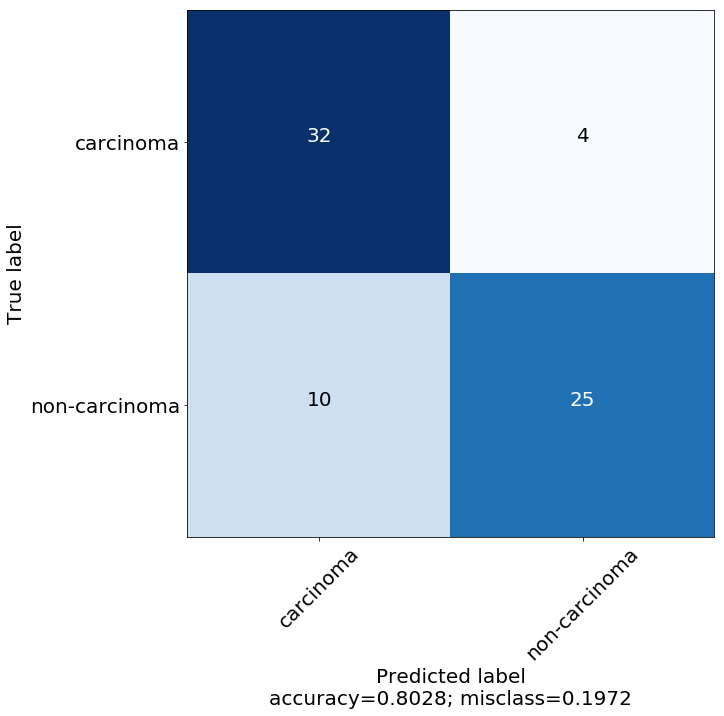

In [19]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[32  4]
 [10 25]]
               precision    recall  f1-score   support

    carcinoma       0.76      0.89      0.82        36
non-carcinoma       0.86      0.71      0.78        35

    micro avg       0.80      0.80      0.80        71
    macro avg       0.81      0.80      0.80        71
 weighted avg       0.81      0.80      0.80        71



In [21]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  76.19047619047619
Specificity :  86.20689655172413


In [22]:
print('roc_auc_score = ' + str(roc_auc_score(predictions, y_true)))

roc_auc_score = 0.8119868637110015


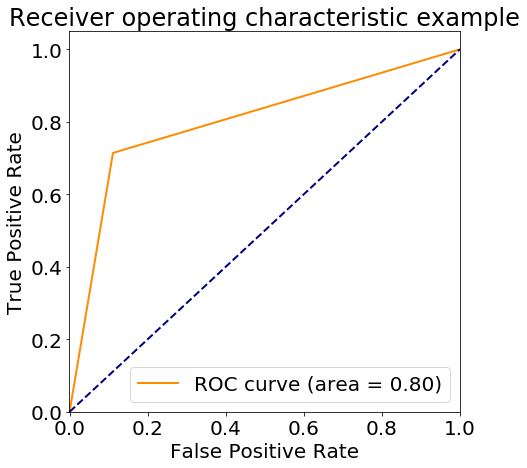

In [23]:
fpr, tpr, thresholds = roc_curve(y_true, predictions)
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-.001, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [24]:
predict = model.predict_proba(test_data, batch_size=batch_size, verbose=1)

71/71 [==============================] - 0s 155us/step


In [25]:
from sklearn.preprocessing import label_binarize

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y = label_binarize(test_labels, classes=[0, 1])
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), predict.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [26]:
from scipy import interp
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

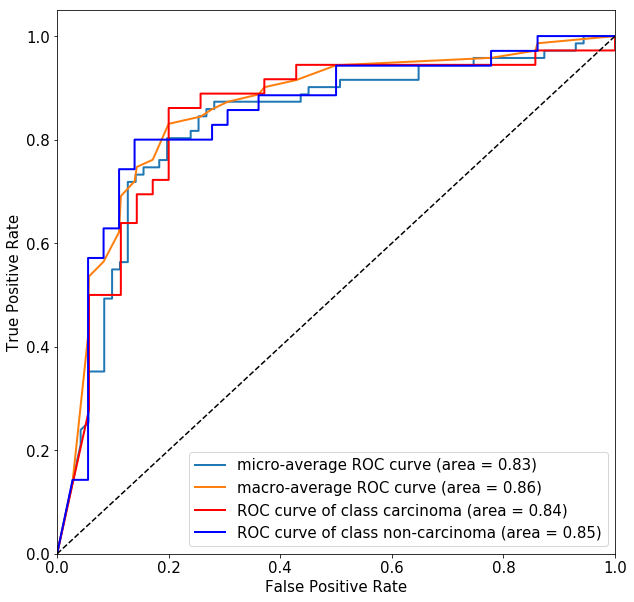

In [27]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 15})

from itertools import cycle
classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)
    

plt.figure(figsize=(10, 10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)
plot_name = 'no variation'
colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [28]:
tn, fp, fn, tp = cm.ravel()

In [29]:
print("Accuracy:",(tp+tn)/(tp+tn+fp+fn))
print("Precision:",(tp/(tp+fp)))
print("Recall:",(tp/(tp+fn)))
print("tp:", tp) 
print("fp:", fp) 
print("tn:",tn) 
print("fn:",fn)

Accuracy: 0.8028169014084507
Precision: 0.8620689655172413
Recall: 0.7142857142857143
tp: 25
fp: 4
tn: 32
fn: 10


In [30]:
print('F1 score:', f1_score(y_true, y_pred))

F1 score: 0.7812500000000001


In [31]:
recall = (tp/(tp+fn))
precision=(tp/(tp+fp))

f1 = 2 / ( (1/recall) + (1 / precision))
print('F1 score:', f1)

F1 score: 0.78125


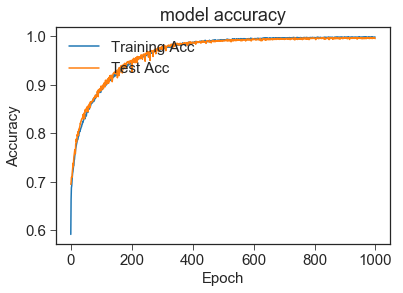

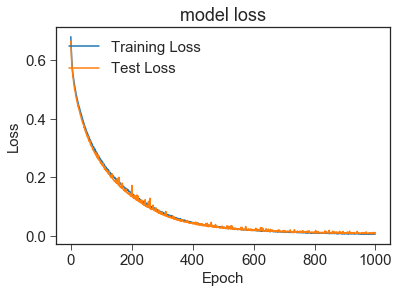

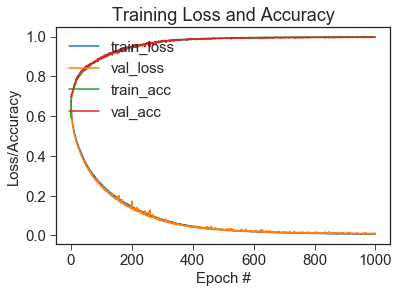

In [32]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")